# Predicting the wave height and period for NDBC buoys
This project focuses on developing predictive models for wave height and wave period using real-time buoy data from the National Data Buoy Center (NDBC). The goal is to design an efficient and accurate forecasting system that leverages environmental and oceanographic variables, such as wind speed, wind direction, water temperature, and atmospheric pressure.

This system could be valuable for offshore energy projects, marine navigation safety, and coastal monitoring systems by providing faster, more reliable wave condition forecasts.

In [20]:
# import libraries needed
from seebuoy import NDBC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [11]:
"""
    Imports data from the National Data Buoy Center (NOAA)
    @param buoy_num: the buoy number of the closest x,y coordinates
    @return see_buoy: the buoy data in a dataframe
"""
ndbc = NDBC()

# Information on NDBC's ~1800 buoys and gliders
wave_df = ndbc.stations()

# list all available data for all buoys
df_data = ndbc.available_data()

# Get info on a single buoy
buoy = ndbc.get_data("44097") #BOSTON BUOY 44097
buoy = buoy.reset_index()
buoy

,date,wind_direction,wind_speed,wind_gust,wave_height,dominant_period,average_period,mean_wave_direction,pressure,air_temp,water_temp,dewpoint,visibility,pressure_tendency,tide
0,2025-03-12 00:26:00,NaN,NaN,NaN,0.5,8,3.9,145.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN
1,2025-03-12 00:56:00,NaN,NaN,NaN,0.5,8,4.1,151.0,NaN,NaN,5.9,NaN,NaN,NaN,NaN
2,2025-03-12 01:26:00,NaN,NaN,NaN,0.5,9,4.2,156.0,NaN,NaN,5.9,NaN,NaN,NaN,NaN
3,2025-03-12 01:56:00,NaN,NaN,NaN,0.4,8,4.1,148.0,NaN,NaN,5.9,NaN,NaN,NaN,NaN
4,2025-03-12 02:26:00,NaN,NaN,NaN,0.5,8,4.3,151.0,NaN,NaN,5.9,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2025-04-26 18:26:00,NaN,NaN,NaN,2.2,6,5.3,179.0,NaN,NaN,8.8,NaN,NaN,NaN,NaN
2188,2025-04-26 18:56:00,NaN,NaN,NaN,2.4,6,5.4,184.0,NaN,NaN,8.8,NaN,NaN,NaN,NaN
2189,2025-04-26 19:26:00,NaN,NaN,NaN,2.5,6,5.6,183.0,NaN,NaN,8.8,NaN,NaN,NaN,NaN
2190,2025-04-26 19:56:00,NaN,NaN,NaN,2.3,6,5.5,181.0,NaN,NaN,8.8,NaN,NaN,NaN,NaN


In [ ]:
#### handler for missing data

def handle_missing_data(buoy):
    """
    The data has some missing values. We impute these values with interpolation.

    @param buoy: the data imported from Seebuoy
    @return buoy_interpolated: a dataframe of buoy data where we impute the missing values
    with interpolation
    """
    # missing data
    # total = buoy.isnull().sum().sort_values(ascending=False)
    # percent = (buoy.isnull().sum() / buoy.isnull().count()).sort_values(
    #     ascending=False
    # )
    # missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
    # missing_data
    
    # dropping rows where average_period is null
    buoy.dropna(subset=['average_period'], inplace=True)

    # dropping rows wehre wave_height is null
    buoy.dropna(subset=['wave_height'], inplace=True)

    # dropping cols where there is 100% NA
    buoy.dropna(axis=1, how='all', inplace=True)

    # IMPUTATIONS

    columns_to_fill = [
        "wind_direction",
        "wind_speed",
        "wind_gust",
        "dominant_period",
        "mean_wave_direction",
        "pressure",
        "air_temp",
        "water_temp",
        "dewpoint",
        "visibility",
        "pressure_tendency",
        "tide"
    ]


    # Interpolate missing values using spline interpolation
    buoy_interpolated = buoy.copy()
    for column in columns_to_fill:
        if column in buoy_interpolated:
            buoy_interpolated[column] = buoy_interpolated[column].fillna(buoy_interpolated[column].interpolate(method='spline', order=2))
    
    # check if there are any additional missing values
    for column in columns_to_fill:
        if column in buoy_interpolated.columns and buoy_interpolated[column].isnull().any():
            buoy_interpolated = buoy_interpolated.drop(column, axis=1)

    return buoy_interpolated

### Handling Missing Data

In [ ]:
total = buoy.isnull().sum().sort_values(ascending=False)
percent = (buoy.isnull().sum() / buoy.isnull().count()).sort_values(
    ascending=False
)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
#missing_data


,Total,Percent
wind_direction,2192,1.000000
wind_speed,2192,1.000000
wind_gust,2192,1.000000
pressure,2192,1.000000
air_temp,2192,1.000000
dewpoint,2192,1.000000
visibility,2192,1.000000
pressure_tendency,2192,1.000000
tide,2192,1.000000
average_period,1,0.000456


In [ ]:
# dropping rows where average_period is null
buoy.dropna(subset=['average_period'], inplace=True)

# dropping rows wehre wave_height is null
buoy.dropna(subset=['wave_height'], inplace=True)

# dropping cols where there is 100% NA
buoy.dropna(axis=1, how='all', inplace=True)
#buoy


In [26]:
columns_to_fill = [
    "wind_direction",
    "wind_speed",
    "wind_gust",
    "dominant_period",
    "mean_wave_direction",
    "pressure",
    "air_temp",
    "water_temp",
    "dewpoint",
    "visibility",
    "pressure_tendency",
    "tide"
]

# Interpolate missing values using spline interpolation
buoy_interpolated = buoy.copy()
for column in columns_to_fill:
    if column in buoy_interpolated:
        buoy_interpolated[column] = buoy_interpolated[column].fillna(buoy_interpolated[column].interpolate(method='spline', order=2))

# check if there are any additional missing values
for column in columns_to_fill:

    # makes sure that interpolated values are valid (not NaN)
    if column in buoy_interpolated.columns and buoy_interpolated[column].isnull().any():
        buoy_interpolated = buoy_interpolated.drop(column, axis=1)

buoy_interpolated


,date,wave_height,dominant_period,average_period,mean_wave_direction,water_temp
0,2025-03-12 00:26:00,0.5,8,3.9,145.0,6.0
1,2025-03-12 00:56:00,0.5,8,4.1,151.0,5.9
2,2025-03-12 01:26:00,0.5,9,4.2,156.0,5.9
3,2025-03-12 01:56:00,0.4,8,4.1,148.0,5.9
4,2025-03-12 02:26:00,0.5,8,4.3,151.0,5.9
...,...,...,...,...,...,...
2187,2025-04-26 18:26:00,2.2,6,5.3,179.0,8.8
2188,2025-04-26 18:56:00,2.4,6,5.4,184.0,8.8
2189,2025-04-26 19:26:00,2.5,6,5.6,183.0,8.8
2190,2025-04-26 19:56:00,2.3,6,5.5,181.0,8.8


In [33]:
def visualize_column_interpolation(original_df, interpolated_df, column_name, datetime_column='date'):
    """
    Plots original vs interpolated values for a specific column with datetime on the x-axis.
    """
    plt.figure(figsize=(14,6))

    # Plot original data
    plt.plot(original_df[datetime_column], original_df[column_name], 
             label='Original', linestyle='--', marker='o', alpha=0.5)
    
    # Plot interpolated data
    plt.plot(interpolated_df[datetime_column], interpolated_df[column_name], 
             label='Interpolated', linestyle='-', marker='.', alpha=0.8)

    plt.title(f'Visualization of {column_name}: Original vs Interpolated')
    plt.xlabel('Datetime')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # rotate dates so they fit better
    plt.tight_layout()
    plt.show()

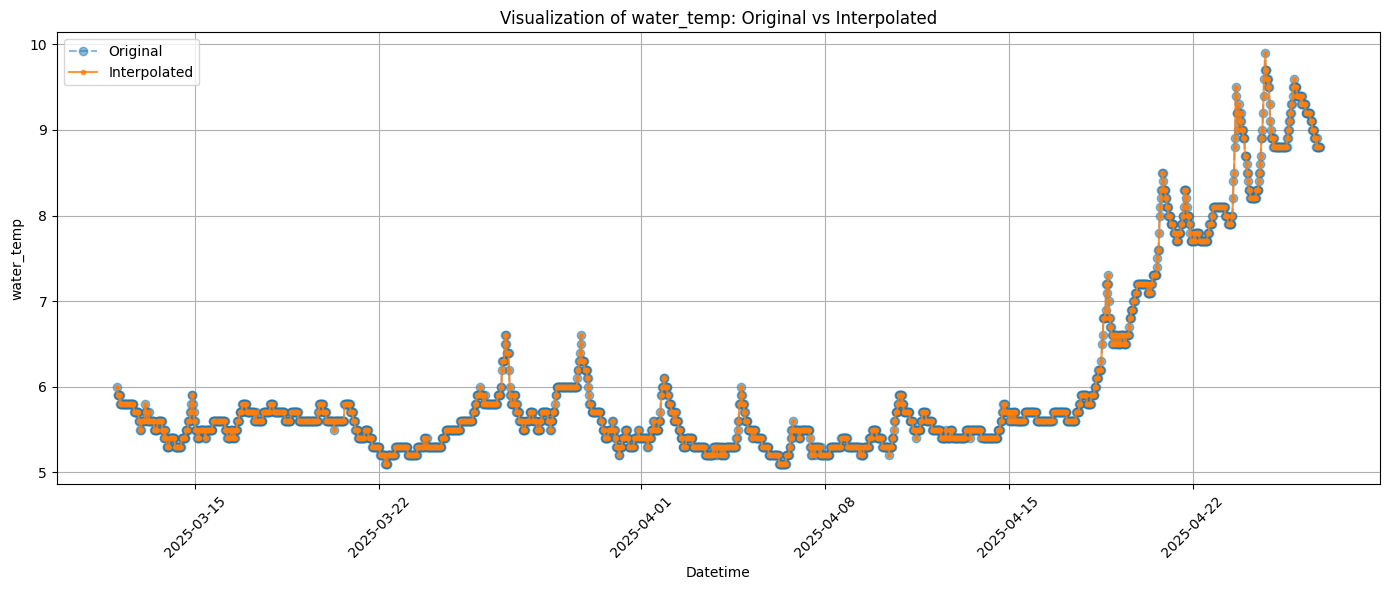

In [35]:
# Example: visualize wind_speed
visualize_column_interpolation(buoy, buoy_interpolated, 'water_temp')

# You can do this for any column you care about
# visualize_column_interpolation(buoy, buoy_interpolated, 'air_temp')
# visualize_column_interpolation(buoy, buoy_interpolated, 'pressure')

In [36]:
buoy_cleaned = handle_missing_data(buoy)

### Exploratory Data Analysis